## HLA-zoo

To know:
- the alignment of each set of reads againts the graphs is done with `rules/alignment_simreads.smk`
- due to the large amount of graphs for the same set of sequences, paths to gfa are indexed and stored in a json file, their identifiers are used to label the `*.gaf` file with the alignment results 
- in each folder you will find a file `gfaid_to_path`, the information to track the source gfa is in that file

In [32]:
import sys
import json
from pathlib import Path
from tqdm import tqdm

# add parent folder to the path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd; tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from utils.load_gaf import load_gaf, ABBV

In [17]:
tool="makeprg"
PATH_TOOL=Path("/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo").joinpath(tool)

with open(Path(PATH_TOOL).joinpath("gfaid_to_paths.json")) as fp:
    gfaid_to_paths=json.load(fp)

In [18]:
path_gaf = list(Path(PATH_TOOL).rglob("*.gaf"))[0]
seqsid, gfaid, _ = path_gaf.stem.split(".")
gfaid = gfaid.replace("gfaid","")
path_gfa = "../"+ gfaid_to_paths[gfaid]

In [19]:
gaf = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf["seqsid"] = seqsid 
gaf["tool"] = tool
gaf["gfa"] = path_gfa

In [28]:
*_, mafft, _ = path_gfa.split("/")
mafft

'output-HLA-zoo-mafft.op5-ep0'

## Generic load

In [23]:
BASEPATH_ALIGN=Path("/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo")

In [24]:
data_gafs = []

for TOOL in ["pangeblocks","pggb","PanPA","vg","makeprg"]:

    # load id to gfas
    with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
        gfaid_to_paths=json.load(fp)

    for path_gaf in tqdm(list(BASEPATH_ALIGN.joinpath(TOOL).rglob("*.gaf")), desc=TOOL):

        # load info related to the gfa
        seqsid, gfaid, _ = path_gaf.stem.split(".")
        gfaid = gfaid.replace("gfaid","")
        path_gfa =  "../" + gfaid_to_paths[gfaid]

        # 
        data_gaf = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
        data_gaf["seqsid"] = seqsid 
        data_gaf["tool"] = TOOL
        data_gaf["gfa"] = path_gfa

        data_gafs.append(data_gaf)

makeprg: 100%|██████████| 78/78 [00:00<00:00, 122.19it/s]


In [25]:
data_gafs=pd.concat(data_gafs, ignore_index=True)

In [29]:
def get_id_plot(path_gfa):

    if "pangeblocks" in path_gfa:
        # loss function info
        *_,mafft,_,loss_func, pen_len,_ = path_gfa.split("/")
        
        op_ep = mafft.split("-mafft.")[-1]
        p, ml = pen_len.split("-")
        
        p=p.replace("penalization","p")
        ml=ml.replace("min_len","l")
        loss_func=loss_func[0]
        return "-".join(["pangeblocks","mafft",op_ep,loss_func,p,ml])
    
    if "pggb" in path_gfa:
        return "pggb"

    if "PanPA" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["panpa","mafft",op_ep])

    if "vg" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["vg","mafft",op_ep])

    if "makeprg" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["makeprg","mafft",op_ep])

In [33]:
data_gafs["id_plot"] = data_gafs["gfa"].progress_apply(get_id_plot)

100%|██████████| 469328/469328 [00:01<00:00, 468722.75it/s]


In [34]:
iter_seqsid=iter(data_gafs["seqsid"].unique())

Text(0.5, 1.0, 'Boxplot | gene B-3106')

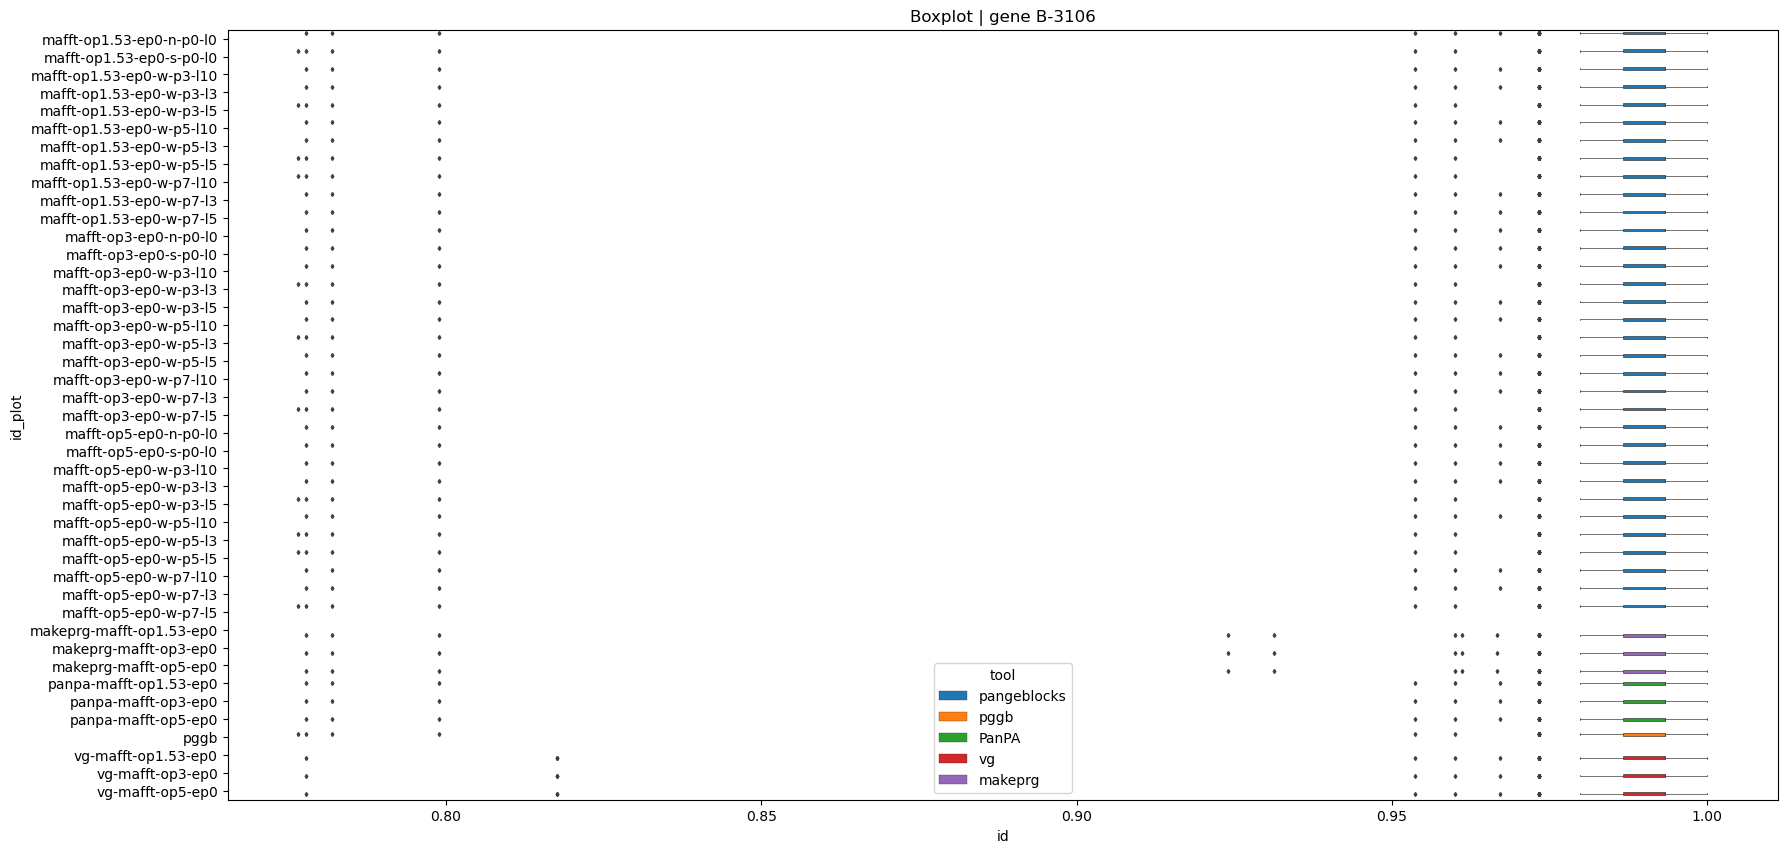

In [35]:
seqid= next(iter_seqsid)
# seqid="C-3107"

data_boxplot = data_gafs.query(f"seqsid=='{seqid}'")
order_labels = sorted(list(data_boxplot["id_plot"].unique()))

plt.figure(figsize=(20,10))
# fig, (ax_boxplot, ax_counts) = plt.subplots(nrows=2, ncols=1,)
ax_boxplot = sns.boxplot(
    data=data_boxplot, 
    x="id",
    y="id_plot",
    orient="h",
    hue="tool",
    order=order_labels,
    saturation=1,
    linewidth=0.5,
    fliersize=2.0,
    )
ax_boxplot.set_title(f"Boxplot | gene {seqid}")

Text(0.5, 1.0, 'Number of aligned reads | gene B-3106')

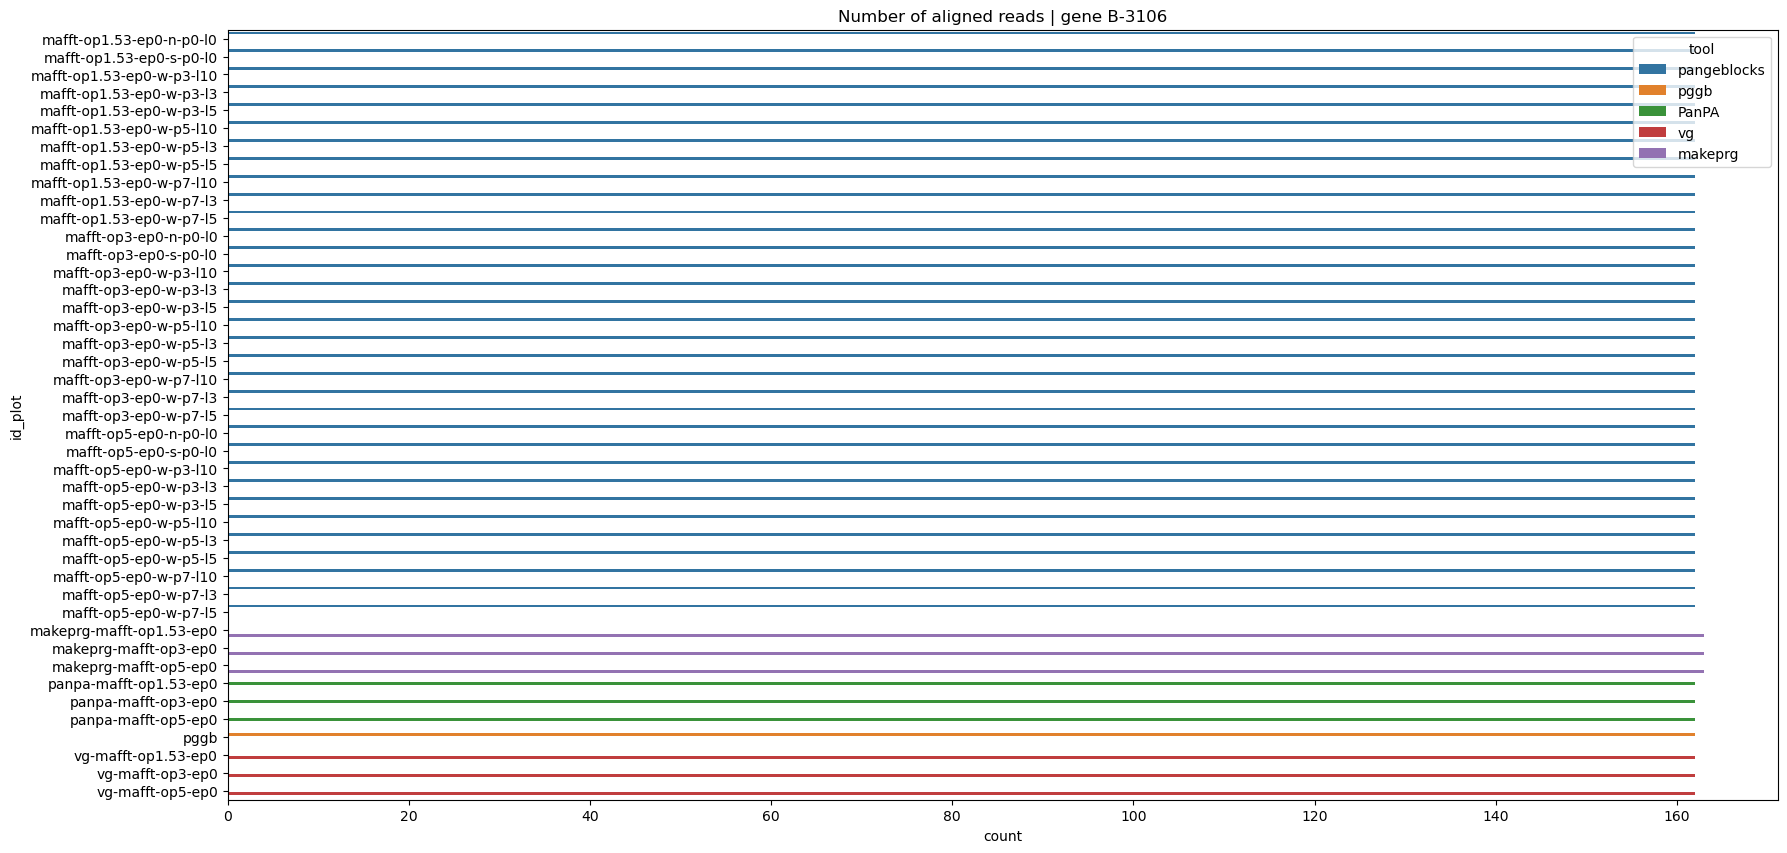

In [36]:
plt.figure(figsize=(20,10))
ax_count=sns.countplot(
    data=data_boxplot, 
    y="id_plot", 
    hue="tool", 
    orient="h", 
    order=order_labels
    )
ax_count.set_title(f"Number of aligned reads | gene {seqid}")


Text(0.5, 1.0, 'Number of existing paths the reads are aligned against | gene B-3106 ')

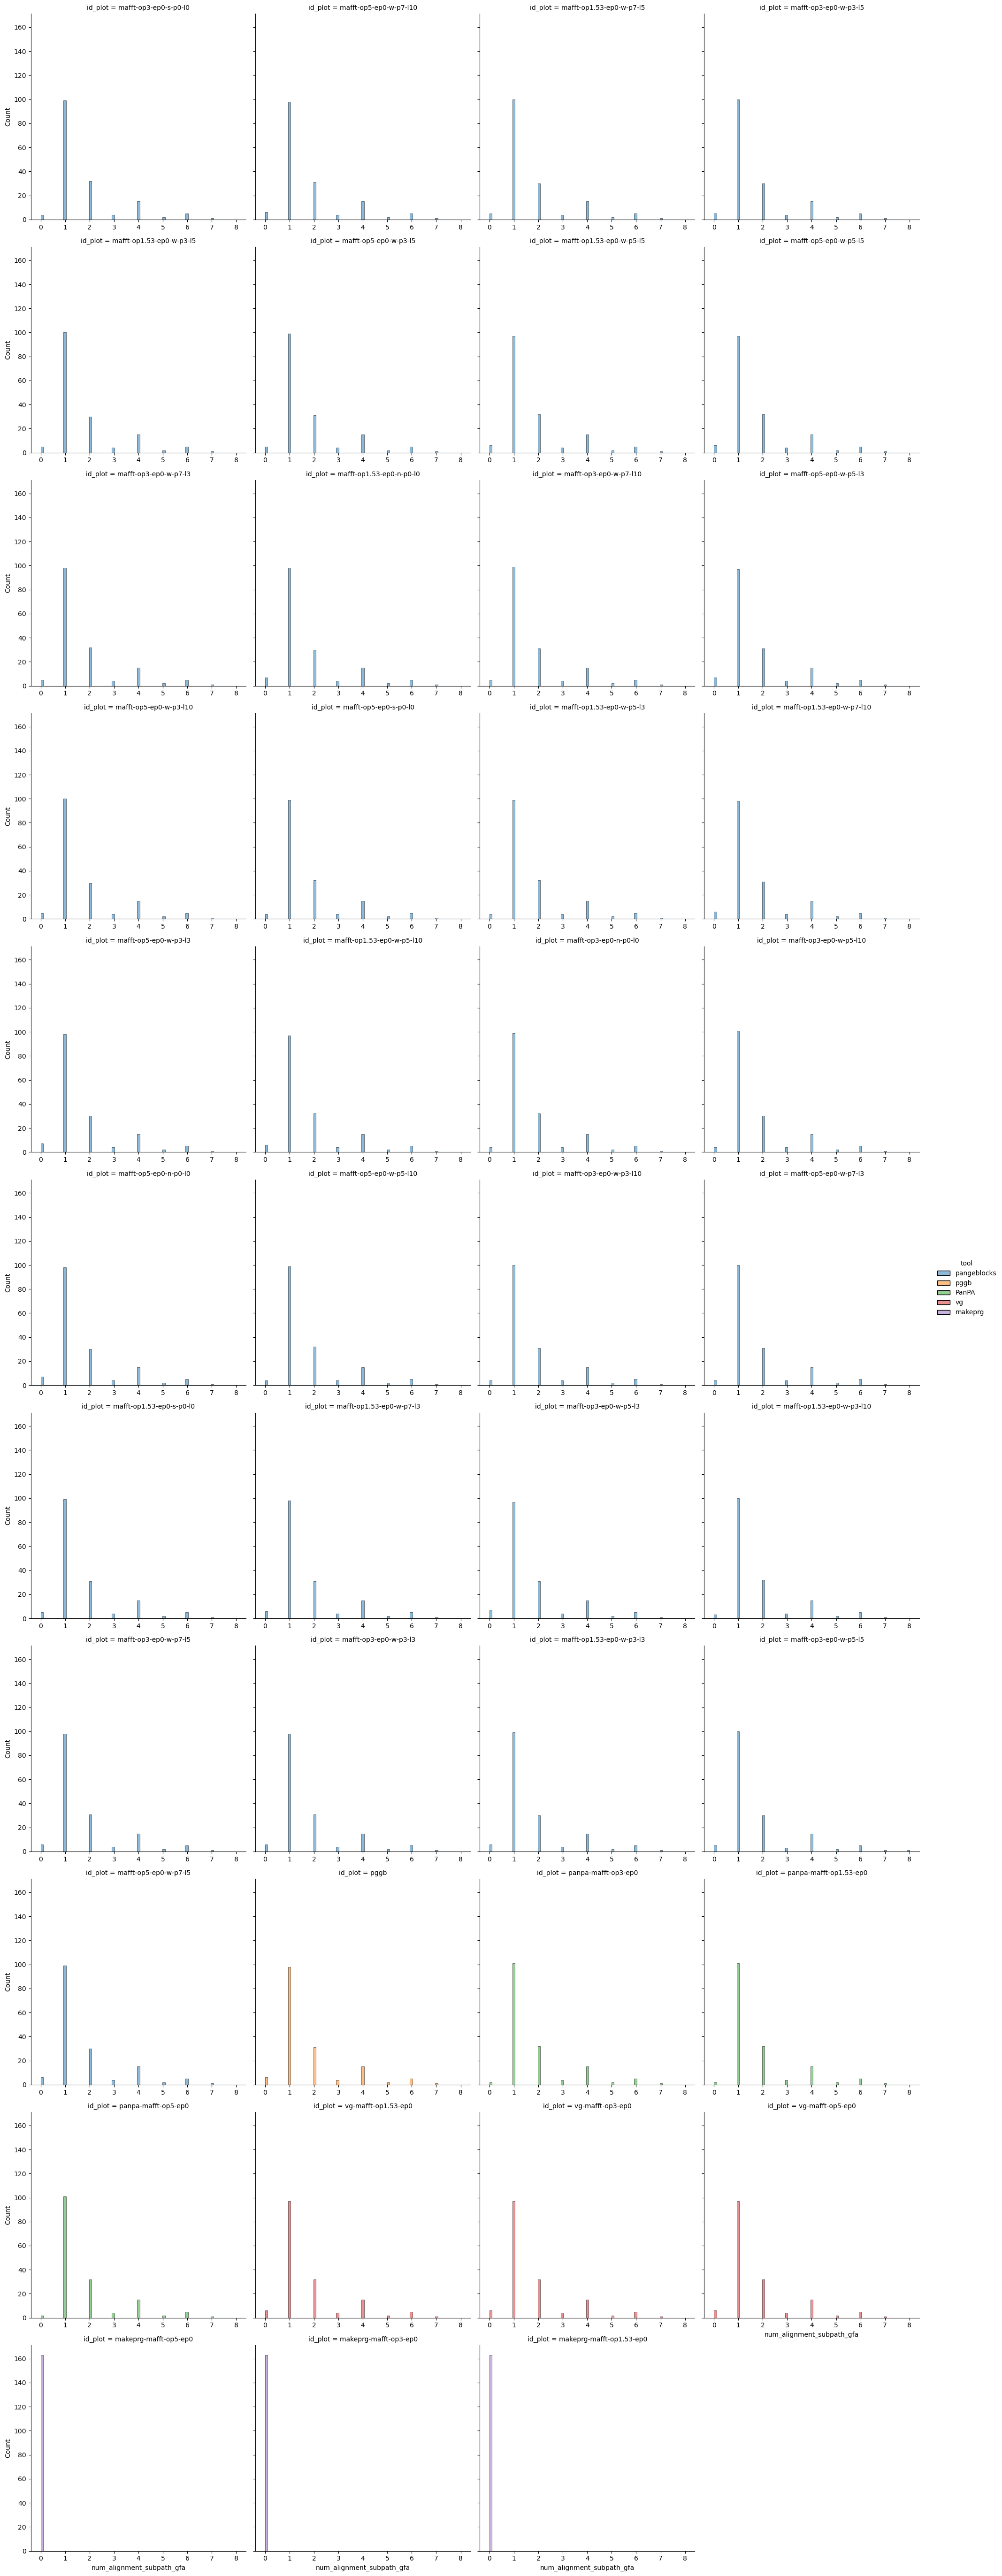

In [37]:
ax_align_subpaths = sns.displot(
    data=data_boxplot,
    col="id_plot",
    x="num_alignment_subpath_gfa",
    hue="tool",
    col_wrap=4,
    facet_kws=dict(sharex=False)
)

ax_count.set_title(f"Number of existing paths the reads are aligned against | gene {seqid} ")


In [38]:
data_boxplot.head()

,query_seq_name,query_seq_len,query_start,query_end,strand_rel_path,path_matching,path_len,start_pos_path,end_pos_path,num_residue_matches,...,NM,AS,dv,id,cigar,num_alignment_subpath_gfa,seqsid,tool,gfa,id_plot
0,gi|568815592:31353871-31357211_2446_2514_0_1_0...,150,0,150,+,>114>351>115>116>227>396>400>350>118>119>120>1...,158,6,156,148,...,2,144.12,dv:f:0.0133333,0.986667,cg:Z:4=1X89=1X55=,1,B-3106,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op3-ep0-s-p0-l0
1,gi|568815592:31353871-31357211_1300_1317_0_1_0...,150,0,150,+,>63>64>226>66>67>69>70>397>71>311>73>325,321,35,185,149,...,1,147.06,dv:f:0.00666667,0.993333,cg:Z:107=1X42=,2,B-3106,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op3-ep0-s-p0-l0
2,gi|568815592:31353871-31357211_1371_1395_0_1_0...,150,0,150,+,>70>397>71>311>73>325,220,5,155,150,...,0,150.00,dv:f:0,1.000000,cg:Z:150=,4,B-3106,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op3-ep0-s-p0-l0
3,gi|568815592:31353871-31357211_146_180_0_1_0_0...,150,0,150,+,>361>286>4>277>278>5>248>303>8>274>10>390>11>1...,275,107,257,150,...,0,150.00,dv:f:0,1.000000,cg:Z:150=,2,B-3106,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op3-ep0-s-p0-l0
4,gi|568815592:31353871-31357211_2514_2547_0_1_0...,150,0,150,+,>121>123>124>389>416>126>258>128>358>129>446>4...,193,6,156,148,...,2,144.12,dv:f:0.0133333,0.986667,cg:Z:70=1X65=1X13=,1,B-3106,pangeblocks,../HLA-zoo-pangeblocks/output-HLA-zoo-mafft.op...,mafft-op3-ep0-s-p0-l0



___
## Checking manually reads for gene C-3107
- Why pggb and vg align less reads than pangeblocks?
- get reads aligned by pangeblocks and not by pggb 
- get reads aligned by pangeblocks and not by vg


In [ ]:
seqid="C-3107"
TOOL="pggb"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/pggb/C-3107/C-3107.gfaid16.alignment.gaf"
path_gfa="../"+gfaid_to_paths["16"]

gaf_pggb = load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_pggb.shape

(160, 18)

<Axes: xlabel='id', ylabel='Count'>

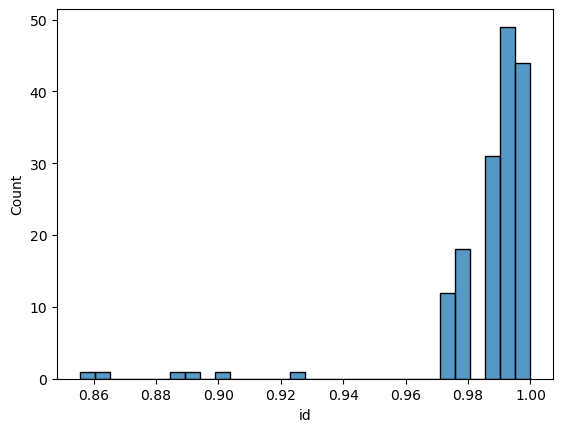

In [ ]:
sns.histplot(data=gaf_pggb,x="id")

In [ ]:
TOOL="vg"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/vg/C-3107/C-3107.gfaid24.alignment.gaf"
path_gfa="../" + gfaid_to_paths["24"]

gaf_vg=load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_vg.shape

(157, 18)

In [ ]:
TOOL="pangeblocks"
with(open(BASEPATH_ALIGN.joinpath(TOOL) / "gfaid_to_paths.json" )) as fp: 
    gfaid_to_paths=json.load(fp)

path_gaf="/data/pangeblocks-experiments/alignment-simulated-reads-HLA-zoo/pangeblocks/C-3107/C-3107.gfaid537.alignment.gaf"
path_gfa="../" + gfaid_to_paths["537"]

gaf_pangeblocks=load_gaf(path_gaf=path_gaf, path_gfa=path_gfa)
gaf_pangeblocks.shape

(161, 18)